# Variational Autoencoder - CelebA data

### Import

In [1]:
import os
import sys
import argparse
import torch
import visdom
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
from collections import defaultdict
from torchvision import transforms
from torch.utils.data import Dataset
from PIL import Image
from tqdm import tqdm
from torch import nn
from torch.autograd import Variable
from torch.nn import functional as F
from lib_cpu.utils import CroppedCelebA
from lib_cpu.models.VAE import VAE

### Parameters

In [2]:
modeltype = 'VAE'
n_epochs=1
start_epoch=0
batch_size=128
lr=0.0001
beta1=0.5
beta2=0.999
n_fil=128
z_dim=88
n_critic=5
n_gen=1                     
use_visdomt=True
visdom_host='http://localhost'
visdom_port=8097
visdom_env='main'
plot_freq=10
chkp_freq=1
preload_model=False
load_dir = '../../data/celeba/models/'
save_dir= '../../data/celeba/models/'
imgs_dir = '../../data/celeba/generated/'
choices=['VAE', 'DCGAN', 'VAEGAN', 'LSGAN', 'WGAN', 'WGANGP', "InfoGAN", 'BEGAN']

### Create VAE Model

In [3]:
n_attrs = 40
viz = visdom.Visdom(server=visdom_host, port=visdom_port, env=visdom_env)
celeba_data = CroppedCelebA("../../data/celeba/")
model = VAE(n_fil, z_dim, n_attrs, viz)

Setting up a new session...


### Initialize

In [4]:
model.init_optimizers(lr, beta1, beta2)
model.n_gen = n_gen
model.n_critic = n_critic
preload_model = True
if preload_model:
    model.load(load_dir,0)

### Training

In [5]:
# model.train_model(celeba_data, n_epochs=n_epochs, batch_size=batch_size,
#                   start_epoch=start_epoch,
#                   models_dir=save_dir, imgs_dir=imgs_dir,
#                   chkp_freq=chkp_freq, plot_freq=plot_freq)
# model.save(save_dir)

### Image Transform

In [6]:
h, w = 218, 178
size = 64, 64
img_transform = transforms.Compose([
    transforms.Lambda(lambda x: x.crop((25, 45, w-25, h-45))),
    transforms.Resize(size=size, interpolation=transforms.InterpolationMode.BICUBIC),
    transforms.ToTensor() ])

### Load, Transform and convert to tensorflow tensor helper function

In [7]:
def load_and_transform(filename,attrs):
    
    sample = Image.open(filename)
    sample = img_transform(sample)
    sample = sample[None, :]
    return sample

### New Dataloader

In [8]:
data_loader = torch.utils.data.DataLoader(celeba_data,
                                          batch_size=32,
                                          shuffle=True,
                                          num_workers=0)
(imgs, attrs) = next(iter(data_loader))

### Reconstruct random image

In [9]:
# index = str(np.random.randint(200000)).zfill(6)
# index = '007442'
# filename = '../../data/celeba/images/' + index + '.jpg'
# img = load_and_transform(filename,attrs)
#imgs[0,:,:,:] = img
x = model.encoder(imgs,attrs)
z_mean = x[:, :model.G.z_dim]
z_log_var = x[:, model.G.z_dim:]
z = model.sample(z_mean, z_log_var)
decoded_imgs = model.G(z, attrs)
Y = decoded_imgs.detach().numpy()[0,:,:,:]
X = imgs.detach().numpy()[0,:,:,:]
X = np.transpose(X,(1,2,0))
Y = np.transpose(Y,(1,2,0))

### Plot

(-0.5, 63.5, 63.5, -0.5)

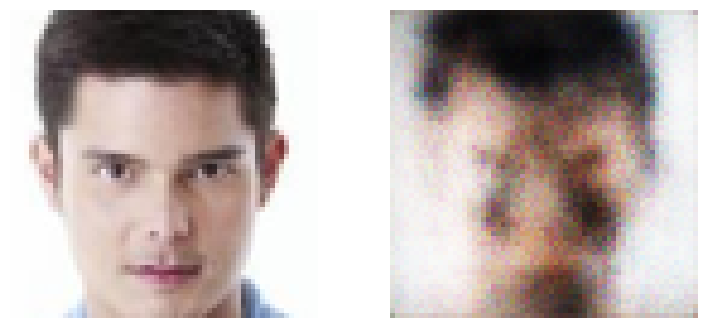

In [10]:
plt.figure(figsize=(9,4))
plt.subplot(1,2,1)
plt.imshow(X)
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(Y)
plt.axis('off')